In [89]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
jit_level = tf.compat.v1.OptimizerOptions.ON_1
config.graph_options.optimizer_options.global_jit_level = jit_level

In [90]:
import keras
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

In [91]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

In [92]:
import python_speech_features
import numpy as np
import soundfile as sf
import pickle
import cv2
import glob

In [93]:
window_length = 19

In [94]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [27]:
#from keras.models import Sequential
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# define model
n_in = 19
with tf.device("/GPU:0"):
    model = Sequential()
    model.add(LSTM(128, activation='tanh', return_sequences=True,input_shape=(19,39)))
    #model.add(Dropout(0.2))
    model.add(LSTM(256, activation='tanh', return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(RepeatVector(n_in))
    model.add(LSTM(256, activation='tanh', return_sequences=True))
    #model.add(Dropout(0.2))
    model.add(LSTM(128, activation='tanh', return_sequences=True))
    #model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(39)))

    model.summary()

    

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 19, 128)           86016     
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               394240    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 19, 256)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 19, 256)           525312    
_________________________________________________________________
lstm_13 (LSTM)               (None, 19, 128)           197120    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 19, 39)            5031      
Total params: 1,207,719
Trainable params: 1,207,719
Non-trainable params: 0
____________________________________________

In [28]:
from keras.models import load_model
model.load_weights('wts_256_tanh.h5')

In [29]:
feat_file = open("/home/orchids/Documents/BTP_Vaishnavi_Joshitha/PartB_Telugu/Train/telugu_feature_vect.pkl", "rb")
sequence = pickle.load(feat_file)

In [30]:
out = model.layers[1].output
m = tf.compat.v1.keras.Model(inputs = model.input, outputs=out)

In [31]:
output = m.predict(sequence)

In [45]:
print(len(output[0]))
print(len(output))

256
195868


In [33]:
features = output
n_gmms=512
from sklearn.mixture import GaussianMixture
gmm_200_512 = GaussianMixture(n_components=n_gmms)

In [34]:
with tf.device("/GPU:0"):
    gmm_200_512.fit(features)

In [35]:
score = gmm_200_512.score_samples(features)

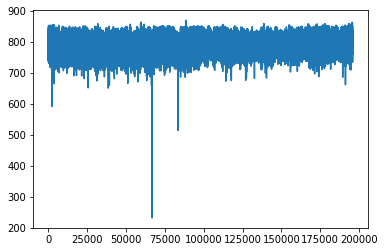

In [36]:
plt.plot(score)

In [38]:
gmm_200_512.lower_bound_

781.7072939009388

In [ ]:
pickle.dump(gmm_200_512, open('gmm_200_512.sav', 'wb'))

In [78]:
import csv
import pandas as pd
list = ['File Name','Sequence']
df = pd.read_csv("/home/orchids/Documents/BTP_Vaishnavi_Joshitha/PartB_Telugu/Train/Transcription_LT_Sequence_Frame_Level_200_actual.tsv", delimiter="\t",names=list)
df['File Name'] = df['File Name'].apply(lambda x: str(x))
for x in range(0,len(df['File Name'])):
  df['File Name'][x] = str(str(df['File Name'][x]).zfill(9))
df

,File Name,Sequence
0,000010010,SSTTTTTTTTTTEEEEEETTSEEEEESSSSTTTTTTSSSSSSSSTT...
1,000010012,SSEEEETTSTTTTTTTTTTTTTTTTTTTTTSS
2,000010017,SSEEETTTTTTTTTTTTTTTTTTTTTTS
3,000010023,SSTTTTTTTTTTTTTTTTTTEESSSSSSEEEEEEETTTTTTTTSS
4,000010030,SSTTTTTTTTTTEETTTS
5,000010035,SSTTTTTTTTTTTTTTSEETTTS
6,000010051,SSSTSTTTTTTTETTTTTTSSTTTTTTTTSS
7,000010107,SSTTTTTTTTTTETTTTTSTTTTTTTTS
8,000010110,SSTEETTTTTTTTTEEESTTEETTTEETTTTS
9,000010138,SSTTTTTTTTTTTTSEEETTSTTTTTTTTTS


SSTTTTTTTTTTTTTTTTTTEESSSSSSEEEEEEETTTTTTTTSS


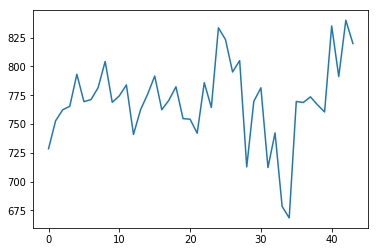

gmm_256_512
S :  728.645476252912
S :  752.8745343840005
T :  762.3765380012237
T :  765.4542980280448
T :  793.1950294971359
T :  769.4614254311163
T :  771.235452429035
T :  781.5694376684936
T :  804.3465387934409
T :  768.8709773574624
T :  774.530518974712
T :  783.981910639952
T :  740.9806095495917
T :  762.4367294810972
T :  775.9405250527772
T :  791.6933661092747
T :  762.4623247442107
T :  770.6608626033558
T :  782.3747075685387
T :  754.7352409606535
E :  754.2047034542325
E :  742.0717239071362
S :  785.8880388365803
S :  764.4153691999757
S :  833.526246818924
S :  823.3138089889565
S :  795.2163659316245
S :  805.0877225329176
E :  712.8628525252894
E :  769.724016301852
E :  781.4697184838594
E :  712.270646121616
E :  742.352454182029
E :  678.5193956398934
E :  668.5510595610762
T :  769.6154111479043
T :  768.7504095974433
T :  773.6328400280233
T :  766.6786853434754
T :  760.5248968300023
T :  835.1672763195949
T :  791.2810059077117
T :  840.1144559117307
S :  81

In [42]:
from keras.models import load_model
model.load_weights('wts_256_tanh.h5')

file_name = '000010023'
file_path ="PartB_Telugu/Train/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = df.loc[df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[1].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_256_512 = gmm_200_512.score_samples(output256)

plt.plot(score_256_512)
plt.show()
print('gmm_256_512')
for i in range(0,len(score_256_512)):
  print(seq[i],": ",score_256_512[i])

GMM : 1024

In [44]:
gmm_256_1024 = GaussianMixture(n_components=1024)

In [46]:
with tf.device("/GPU:0"):
    gmm_256_1024.fit(output)

In [47]:
pickle.dump(gmm_256_1024, open('gmm_256_1024.sav', 'wb'))

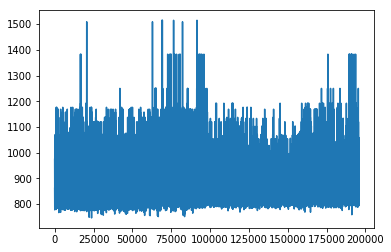

In [48]:
score = gmm_256_1024.score_samples(output)
plt.plot(score)

SSTTTTTTTTTTTTTTTTTTEESSSSSSEEEEEEETTTTTTTTSS


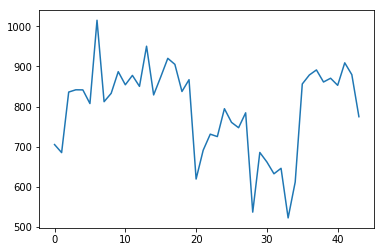

gmm_256_1024
S :  705.4073887744212
S :  685.3756872127744
T :  836.083144622039
T :  841.7235539728701
T :  841.522576740264
T :  807.4805002490544
T :  1014.8825468734664
T :  812.1406947135724
T :  832.9085531333099
T :  886.8818553957734
T :  854.2318177378394
T :  877.5542738961013
T :  850.258747712133
T :  950.2413829440361
T :  828.9796395292611
T :  873.7031034025226
T :  920.0623842733761
T :  905.0567528306233
T :  837.4935321579491
T :  866.9003895365419
E :  619.5918136789445
E :  691.2944659053538
S :  731.255671563547
S :  725.2563737478282
S :  794.6921388713746
S :  760.6870363890754
S :  747.348287111545
S :  784.4447252449921
E :  537.2001382927644
E :  685.7431192266652
E :  662.0436803404817
E :  632.6619396335419
E :  646.3167973205057
E :  522.7908883075067
E :  612.058246569536
T :  856.2322977553114
T :  878.6343574552119
T :  891.1850401353919
T :  861.1344813554549
T :  870.5104703546308
T :  852.8450670742578
T :  908.8905070239649
T :  879.4107377411226
S :

In [51]:
from keras.models import load_model
model.load_weights('wts_256_tanh.h5')

file_name = '000010023'
file_path ="PartB_Telugu/Train/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = df.loc[df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[1].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_256_1024 = gmm_256_1024.score_samples(output256)

plt.plot(score_gmm_256_1024)
plt.show()
print('gmm_256_1024')
for i in range(0,len(score_256_1024)):
  print(seq[i],": ",score_256_1024[i])

In [81]:
import csv
import pandas as pd
list = ['File Name','Sequence']
df = pd.read_csv("/home/orchids/Documents/BTP_Vaishnavi_Joshitha/PartB_Telugu/Dev/Transcription_LT_Sequence_Frame_Level_200_actual.tsv", delimiter="\t",names=list)
df['File Name'] = df['File Name'].apply(lambda x: str(x))
for x in range(0,len(df['File Name'])):
  df['File Name'][x] = str(str(df['File Name'][x]).zfill(9))
df

,File Name,Sequence
0,000010162,SSTTEEETTTEETTTTTTTTTTTTSTTTTTTTSSSTTSS
1,000010210,SSTTTTTEEETTTTTTTTTTTTTTSSSS
2,000010234,SSEEEEETTTTTTTETTTSS
3,000010288,SSSSSEEETTTSSSSEEETTTTTTSTTTTTTTTTTTTTSTTTTTTT...
4,000010443,SSSSSSSSSTTTEEETTSETTTTTTTTTTTTTTTTSS
5,000010450,SSEEETTTTTTTTTTTTSSSSSSSSTTTTTSSTTTTTTTTSS
6,000020052,SSTTTTEETTTTTTSTTTTTTTTTTTTTTTTTSS
7,000020249,SSSTTTTTTTTTTTEETTTTSEETTTTETTTTTTSS
8,000020298,SSTTTTEEETTTTTTTTTTTTTTTTTTTTTTTTTTSS
9,000030204,SSTTTTTTTEEEETTTTTTTTSTTTTTTTTTTTT


SSEEEEETTTTTTTETTTSS


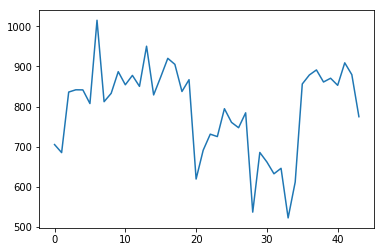

gmm_256_1024
S :  766.2064480503084
S :  750.5333565849363
E :  632.1866231545315
E :  659.9082031207697
E :  670.381216112581
E :  632.140934679208
E :  671.4225058638981
T :  439.99308135453504
T :  587.4313019756418
T :  662.6611174581903
T :  684.9800108109009
T :  662.4481145576063
T :  655.2418736030654
T :  582.1054301179545
E :  595.0455327541459
T :  603.8276019936808
T :  653.7337936092547
T :  757.663257999835
S :  763.0608085267268


In [55]:
from keras.models import load_model
model.load_weights('wts_256_tanh.h5')

file_name = '000010234'
file_path ="PartB_Telugu/Dev/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = df.loc[df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[1].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_256_1024 = gmm_256_1024.score_samples(output256)

plt.plot(score_gmm_256_1024)
plt.show()
print('gmm_256_1024')
for i in range(0,len(score_256_1024)):
  print(seq[i],": ",score_256_1024[i])

In [56]:
gmm_256_2048 = GaussianMixture(n_components=2048)

In [57]:


with tf.device("/GPU:0"):
    gmm_256_2048.fit(output)

In [58]:
pickle.dump(gmm_256_2048, open('gmm_256_2048.sav', 'wb'))

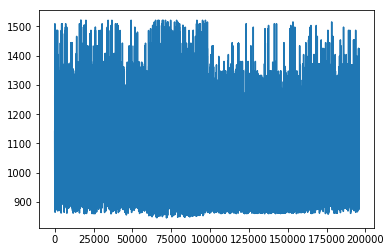

In [59]:
score = gmm_256_2048.score_samples(output)
plt.plot(score)

SSTTTTTTTTTTTTTTTTTTEESSSSSSEEEEEEETTTTTTTTSS


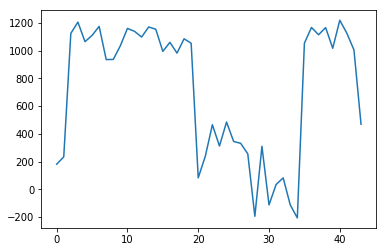

gmm_256_2048
S :  181.4203828915402
S :  234.28406112585498
T :  1123.9909394220115
T :  1205.3024456467217
T :  1064.6108869260388
T :  1109.411440465646
T :  1174.6087963818657
T :  935.4370399664102
T :  936.3846351181932
T :  1035.3788683551725
T :  1159.754487022287
T :  1138.906986323923
T :  1097.7940783675556
T :  1170.2513943639344
T :  1154.088283876145
T :  994.5095156010377
T :  1059.7863440759295
T :  981.9138427888231
T :  1085.093772234919
T :  1052.9378980135837
E :  83.55800903973262
E :  238.89556839702522
S :  465.9219501460536
S :  312.49665015640346
S :  485.3768323434867
S :  345.5355520196708
S :  331.7093882212439
S :  256.08791731957757
E :  -193.723514897416
E :  310.51061176205803
E :  -111.79427218039778
E :  34.99060987461975
E :  82.89674471914249
E :  -111.47593134001487
E :  -205.58375219563146
T :  1053.6872189673638
T :  1167.049162394857
T :  1114.3120137317876
T :  1165.886092044836
T :  1016.7414151173679
T :  1218.8560506370643
T :  1124.8981770572

In [80]:
from keras.models import load_model
model.load_weights('wts_256_tanh.h5')

file_name = '000010023'
file_path ="PartB_Telugu/Train/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = df.loc[df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[1].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_256_2048 = gmm_256_2048.score_samples(output256)

plt.plot(score_256_2048)
plt.show()
print('gmm_256_2048')
for i in range(0,len(score_256_2048)):
  print(seq[i],": ",score_256_2048[i])

SSEEEEETTTTTTTETTTSS


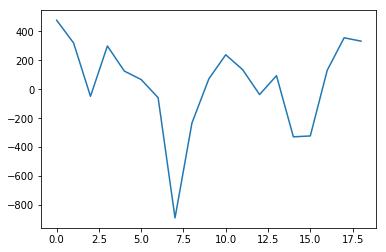

gmm_256_1024
S :  477.11966254918616
S :  320.0541506155049
E :  -48.78999155128258
E :  299.0455449400629
E :  125.64015904983148
E :  66.68700093507745
E :  -58.46947938859499
T :  -889.8418258773517
T :  -233.64700537193005
T :  71.98866334768685
T :  238.35376162598027
T :  135.08288587340357
T :  -36.80881742810458
T :  93.83605167883856
E :  -329.15374894147806
T :  -323.04112127228035
T :  130.89247585999777
T :  355.854189915808
S :  332.58677680184303


In [83]:
from keras.models import load_model
model.load_weights('wts_256_tanh.h5')

file_name = '000010234'
file_path ="PartB_Telugu/Dev/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = df.loc[df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[1].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_256_2048 = gmm_256_2048.score_samples(output256)

plt.plot(score_256_2048)
plt.show()
print('gmm_256_1024')
for i in range(0,len(score_256_2048)):
  print(seq[i],": ",score_256_2048[i])

SSSSSSSSSTTTEEETTSETTTTTTTTTTTTTTTTSS


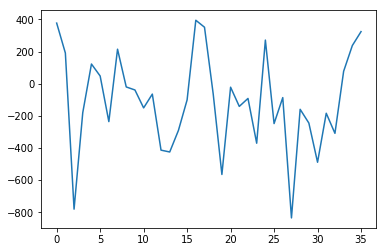

gmm_256_2048
S :  377.48535102518645
S :  191.14920490756333
S :  -780.8175061730711
S :  -180.40416483954965
S :  122.73787550921784
S :  48.13658594013982
S :  -235.83015295582408
S :  214.8813460815319
S :  -20.019895155062258
T :  -38.8990843373977
T :  -150.4300577561819
T :  -64.60418060889992
E :  -413.4487457148333
E :  -424.911619517157
E :  -290.86546348454783
T :  -100.53031318589655
T :  395.1985505313583
S :  351.7029775339279
E :  -63.37195877487635
T :  -564.9194310002168
T :  -21.586109326399587
T :  -141.16699339294598
T :  -91.51464587312353
T :  -370.3614805742376
T :  271.6963626046934
T :  -248.0403498218506
T :  -86.34640007205267
T :  -835.3600941657404
T :  -159.35275783951727
T :  -244.79825194001637
T :  -488.8898195233504
T :  -183.82930823210415
T :  -308.76181679766285
T :  77.59231873073499
T :  237.73710428497282
S :  324.3966960227248


In [85]:
from keras.models import load_model
model.load_weights('wts_256_tanh.h5')

file_name = '000010443'
file_path ="PartB_Telugu/Dev/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = df.loc[df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[1].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_256_2048 = gmm_256_2048.score_samples(output256)

plt.plot(score_256_2048)
plt.show()
print('gmm_256_2048')
for i in range(0,len(score_256_2048)):
  print(seq[i],": ",score_256_2048[i])

4096

In [88]:
gmm_256_4096 = GaussianMixture(n_components=4096)

with tf.device("/GPU:0"):
    gmm_256_4096.fit(output)
    
pickle.dump(gmm_256_4096, open('gmm_256_4096.sav', 'wb'))

score = gmm_256_4096.score_samples(output)
plt.plot(score)

MemoryError: 

In [16]:
tf.config.list_physical_devices('XLA_GPU')

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]